In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import zipfile
import requests

# 下载数据集
url = 'http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip'
save_path = 'hotdog.zip'

if not os.path.exists('hotdog'):
    print("Downloading dataset...")
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    with zipfile.ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    os.remove(save_path)
    print("Dataset downloaded and extracted.")

In [8]:
# 数据预处理
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
train_dataset = datasets.ImageFolder('hotdog/train', transform=transform_train)
test_dataset = datasets.ImageFolder('hotdog/test', transform=transform_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
def build_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    return model

def build_vgg16():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    return model

In [10]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 训练阶段
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # 计算训练指标
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # 计算验证指标
        val_loss = val_loss / len(test_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # 更新最佳准确率
        if val_acc > best_acc:
            best_acc = val_acc

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

    return train_losses, train_accs, val_losses, val_accs, best_acc

In [11]:
# 训练ResNet-18
print("Training ResNet-18...")
model_resnet = build_resnet18()
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
train_loss_res, train_acc_res, val_loss_res, val_acc_res, best_resnet = train_model(model_resnet, criterion, optimizer_resnet, 10)

# 训练VGG-16
print("Training VGG-16...")
model_vgg = build_vgg16()
optimizer_vgg = torch.optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
train_loss_vgg, train_acc_vgg, val_loss_vgg, val_acc_vgg, best_vgg = train_model(model_vgg, criterion, optimizer_vgg, 10)

Training ResNet-18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Epoch 1/10
Train Loss: 0.3736 Acc: 0.8295
Val Loss: 0.1826 Acc: 0.9263

Epoch 2/10
Train Loss: 0.2106 Acc: 0.9220
Val Loss: 0.1439 Acc: 0.9337

Epoch 3/10
Train Loss: 0.2101 Acc: 0.9155
Val Loss: 0.1411 Acc: 0.9437

Epoch 4/10
Train Loss: 0.1615 Acc: 0.9365
Val Loss: 0.1255 Acc: 0.9400

Epoch 5/10
Train Loss: 0.1337 Acc: 0.9505
Val Loss: 0.1197 Acc: 0.9537

Epoch 6/10
Train Loss: 0.1366 Acc: 0.9450
Val Loss: 0.1196 Acc: 0.9450

Epoch 7/10
Train Loss: 0.1464 Acc: 0.9430
Val Loss: 0.1264 Acc: 0.9537

Epoch 8/10
Train Loss: 0.1297 Acc: 0.9535
Val Loss: 0.1138 Acc: 0.9500

Epoch 9/10
Train Loss: 0.1098 Acc: 0.9575
Val Loss: 0.1159 Acc: 0.9487

Epoch 10/10
Train Loss: 0.0976 Acc: 0.9595
Val Loss: 0.1103 Acc: 0.9513

Training VGG-16...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100.0%


Epoch 1/10
Train Loss: 0.2476 Acc: 0.8920
Val Loss: 0.1297 Acc: 0.9487

Epoch 2/10
Train Loss: 0.1952 Acc: 0.9205
Val Loss: 0.1340 Acc: 0.9400

Epoch 3/10
Train Loss: 0.1433 Acc: 0.9485
Val Loss: 0.1346 Acc: 0.9313

Epoch 4/10
Train Loss: 0.1376 Acc: 0.9495
Val Loss: 0.1334 Acc: 0.9375

Epoch 5/10
Train Loss: 0.1158 Acc: 0.9565
Val Loss: 0.1231 Acc: 0.9463

Epoch 6/10
Train Loss: 0.1055 Acc: 0.9610
Val Loss: 0.0962 Acc: 0.9625

Epoch 7/10
Train Loss: 0.0949 Acc: 0.9640
Val Loss: 0.1144 Acc: 0.9513

Epoch 8/10
Train Loss: 0.1041 Acc: 0.9570
Val Loss: 0.1747 Acc: 0.9263

Epoch 9/10
Train Loss: 0.0936 Acc: 0.9625
Val Loss: 0.1514 Acc: 0.9413

Epoch 10/10
Train Loss: 0.0796 Acc: 0.9750
Val Loss: 0.0965 Acc: 0.9613



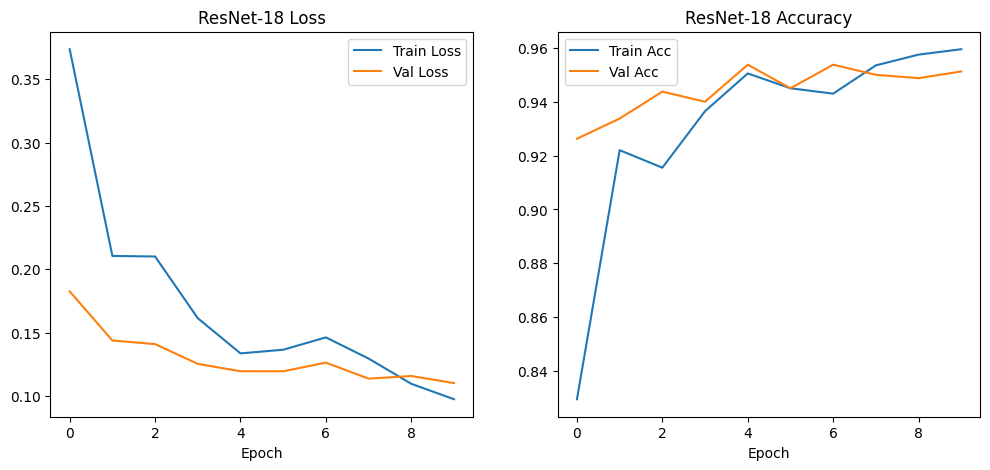

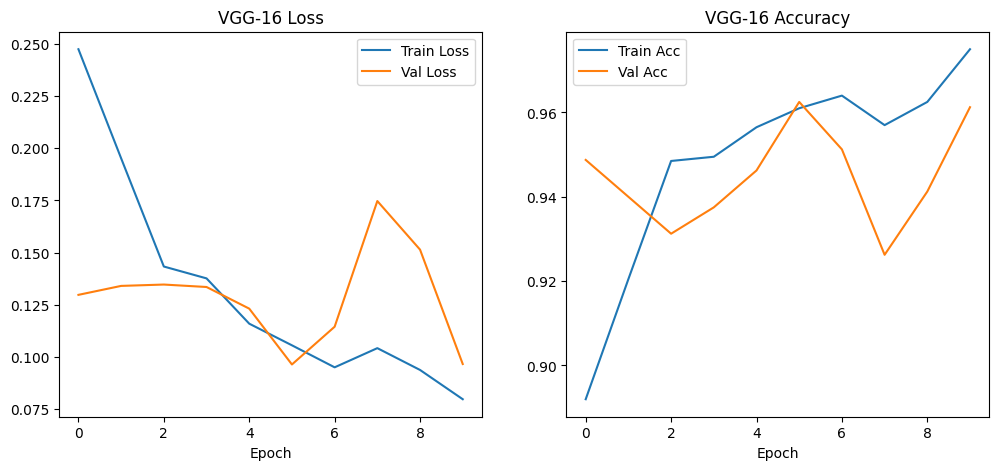

In [12]:
def plot_curves(model_name, train_loss, train_acc, val_loss, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_curves('ResNet-18', train_loss_res, train_acc_res, val_loss_res, val_acc_res)
plot_curves('VGG-16', train_loss_vgg, train_acc_vgg, val_loss_vgg, val_acc_vgg)

In [13]:
print("| 模型 | 训练准确率 | 测试准确率 |")
print("| --- | --- | --- |")
print(f"| ResNet-18 | {train_acc_res[-1]:.4f} | {val_acc_res[-1]:.4f} |")
print(f"| VGG-16 | {train_acc_vgg[-1]:.4f} | {val_acc_vgg[-1]:.4f} |")

| 模型 | 训练准确率 | 测试准确率 |
| --- | --- | --- |
| ResNet-18 | 0.9595 | 0.9513 |
| VGG-16 | 0.9750 | 0.9613 |
